In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

from utils.dice_score import dice_coeff
from utils.dataset import BuildingDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

import segmentation_models_pytorch as smp
from sklearn.model_selection import StratifiedKFold

from test_config import *
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

skf = StratifiedKFold(n_splits=cv)
num_cv_samples = []
_pred_masks = torch.empty(0).to(device)
_val_masks = torch.empty(0).to(device)
_test_masks = []
for i, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(df)), df['ratio'] > 0)):
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    
    val_dataset = BuildingDataset(val_df, val_transform)
    test_dataset = BuildingDataset(test_df, transform=val_transform, root='test')

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
        shuffle=False
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
        shuffle=False
    )

    # init model
    model = getattr(smp, model_cfg.arch)(**model_cfg.hparams)
    
    grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
    criterion = nn.BCEWithLogitsLoss()

    # eval
    model.load_state_dict(torch.load(f'{prefix_save}_best_cv_{i + 1}.pt'))
    model.eval()
    num_cv_samples.append(len(val_dataset))
    cv_test_masks = np.empty(0)
    with torch.no_grad():
        for images, true_masks in val_loader:
            images = images.to(device)
            true_masks = true_masks.to(device)
            model = model.to(device)

            _pred_masks = torch.concat([_pred_masks, model(images).squeeze(1)], axis=0)
            _val_masks = torch.concat([_val_masks, true_masks], axis=0)  
    
        # test
        for images in test_loader:
            images = images.to(device)
            model = model.to(device)

            preds = model(images).squeeze(1).cpu().numpy()
            if len(cv_test_masks) == 0:
                cv_test_masks = preds
            else:
                cv_test_masks = np.concatenate([cv_test_masks, preds], axis=0)
        _test_masks.append(cv_test_masks)

/home/surayuth/miniconda3/envs/kaggle/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def remove_blob(mask, min_size):
    # find all of the connected components (white blobs in your image).
    # im_with_separated_blobs is an image where each detected blob has a different pixel value ranging from 1 to nb_blobs - 1.
    nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(mask.astype(np.uint8))
    # stats (and the silenced output centroids) gives some information about the blobs. See the docs for more information. 
    # here, we're interested only in the size of the blobs, contained in the last column of stats.
    sizes = stats[:, -1]
    # the following lines result in taking out the background which is also considered a component, which I find for most applications to not be the expected output.
    # you may also keep the results as they are by commenting out the following lines. You'll have to update the ranges in the for loop below. 
    sizes = sizes[1:]
    nb_blobs -= 1

    # minimum size of particles we want to keep (number of pixels).
    # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever.
    # min_size = 150

    # output image with only the kept components
    im_result = np.zeros_like(im_with_separated_blobs)
    # for every component in the image, keep it only if it's above min_size
    for blob in range(nb_blobs):
        if sizes[blob] >= min_size:
            # see description of im_with_separated_blobs above
            im_result[im_with_separated_blobs == blob + 1] = 255
    return im_result // 255


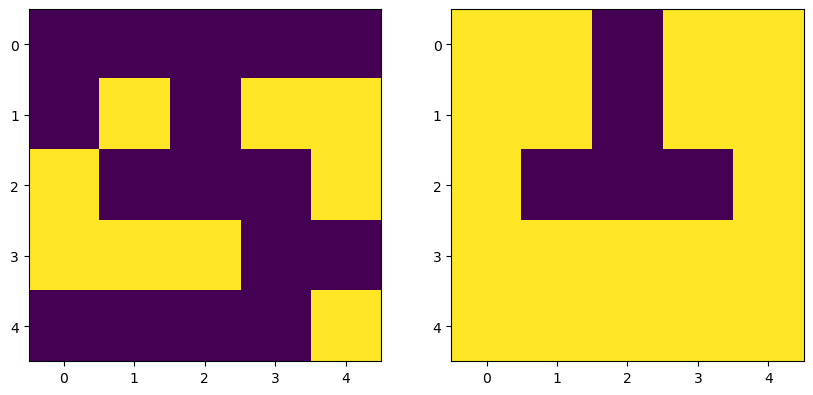

In [3]:
_tmp = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1]
])

def fill_edge(img, d=2):
    _tmp = img.copy()
    H, W = _tmp.shape
    tmp = _tmp.copy()
    # fill vertical
    for i in range(W):
        for s in range(1, d+1):
            # top
            if tmp[s, i]:
                tmp[:s, i] = 1
            # bottom
            if tmp[(H-1) -s, i]:
                tmp[H - s:H, i] = 1

    # fill horizontal
    for i in range(H):
        for s in range(1, d+1):
            # left
            if tmp[i, s]:
                tmp[i, :s] = 1
            # right
            if tmp[i, (W-1) - s]:
                tmp[i, W-s:W] = 1
    return tmp

    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(_tmp)
axs[1].imshow(fill_edge(_tmp))

In [4]:
# test_masks = np.array(_test_masks) # CV, N_test, H, W
# avg_test_masks = test_masks.mean(axis=0)
# test_logits = avg_test_masks.reshape(-1, 224 * 224)
# test_ratios =  (1 / (1 + np.exp(-test_logits)) > 0.5).mean(axis=1)


In [5]:
np.array(_test_masks).shape

(5, 1358, 224, 224)

In [6]:
test_masks = np.array(_test_masks).mean(axis=0) #N_test, H, W

fill = False
fill_e = False
for i in tqdm(range(len(test_masks))):
    # fill hole
    th_mask = ((1 / (1 + np.exp(-test_masks[i])) > 0.5) * 1).astype(np.uint8)
    if fill:
        closing = cv2.morphologyEx(th_mask, cv2.MORPH_CLOSE, np.ones((3, 3)))
    else:
        closing = th_mask.copy()
    test_masks[i] = closing.copy()
    
    # fill gabs at edges
    if fill_e:
        test_masks[i] = fill_edge(test_masks[i], d=5)

test_ratios = test_masks.reshape(-1, 224 * 224).mean(axis=-1)
test_result = pd.DataFrame({'ratio': test_ratios})
test_result.to_csv(f'test_results/{prefix_save}.csv', index=False)

100%|██████████| 1358/1358 [00:00<00:00, 11314.18it/s]


830


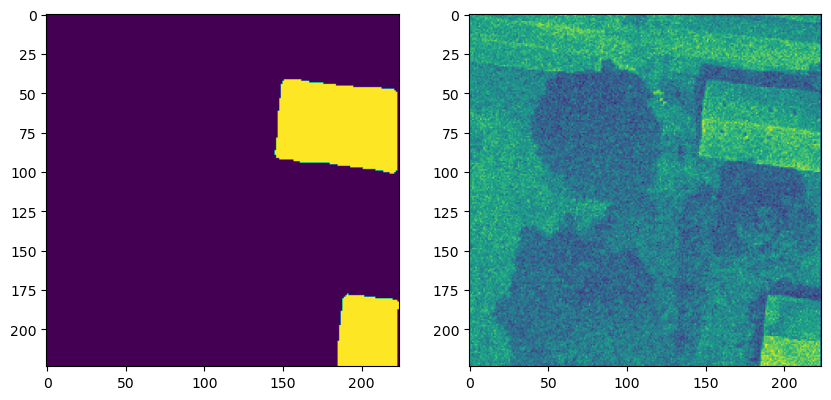

In [ ]:
# nz_idxs = np.nonzero(test_ratios > 0)[0]
# print(len(nz_idxs))
# nz_idx = 24
# file = test_df.iloc[nz_idxs[nz_idx]].file
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(1 / (1 + np.exp(-avg_test_masks[nz_idxs[nz_idx]])) > 0.5)
# axs[1].imshow(cv2.imread(f'test/{file}', cv2.IMREAD_GRAYSCALE))

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['ratio'] = test_ratios
submission.to_csv('en_dlv3p_effb0_p05_post.csv', index=False)

In [ ]:
submission.to

,file,ratio
0,g_0.png,0.000000
1,g_1.png,0.000000
2,g_2.png,0.007215
3,g_9.png,0.000000
4,g_12.png,0.000000
...,...,...
1353,g_4595.png,0.569037
1354,g_4602.png,0.499601
1355,g_4606.png,0.000000
1356,g_4607.png,0.000000


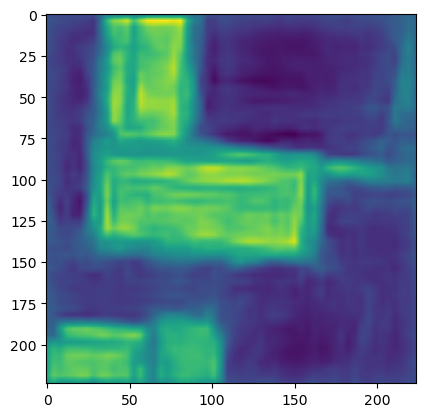

In [ ]:
plt.imshow(test_masks.mean(axis=0)[-1])

In [ ]:
def opt_func(ws, preds=_pred_masks, targets=_val_masks, num_cv_samples=num_cv_samples):
    total_ws = []
    for i, w in enumerate(ws):
        total_ws += [w] * num_cv_samples[i]
    total_ws = torch.tensor(total_ws).reshape(-1, 1, 1).to(device)
    
    th_masks = (F.sigmoid(total_ws * preds) > total_ws).cpu().numpy()
    targets = targets.cpu().numpy()

    pred_ratios = th_masks.reshape(len(preds), -1).mean(axis=-1)
    val_ratios = targets.reshape(len(preds), -1).mean(axis=-1)
    return ((pred_ratios - val_ratios) ** 2).mean()

In [ ]:
from scipy.optimize import minimize

#w_en = [.1, .1, .1, .1, .1] #[1., 1., 1., 1., 1.]
p_en = [.9] * 5
w = np.array(p_en)

res = minimize(opt_func,
               x0=w,
               method='SLSQP',
            #    constraints=[
            #        {'type': 'eq', 'fun': lambda x: np.sum(x[:5])},
            #        {'type': 'ineq', 'fun': lambda x: np.sum(x[5:])},
            #        {'type': 'ineq', 'fun': lambda x: 1 - np.sum(x[5:])}
            #        ],
               bounds=[(0, 1) for _ in range(len(w))]
               )
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.002878531978206874
       x: [ 9.000e-01  9.000e-01  9.000e-01  9.000e-01  8.999e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  3.659e-02]
    nfev: 17
    njev: 1
